# TPE - FUNDAMENTOS DE LA CIENCIA DE DATOS - 2025 
## ONLINE SHOPPERS INTENTION DATASET

Autores: Cisilino Bautista y Abraham Simon

#### Apertura y analisis preeliminar del dataset.

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats  

from wget import download
from os import path

# leemos los datos del archivo
dataset_compras = pd.read_csv("online_shoppers_intention.csv")
dataset_compras.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


Mostramos los primeros 5 registros/muestras del dataset, para ver con que variables nos encontrabamos, el tipo y los posibles valores que podrian tomar.

In [41]:
dataset_compras.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [42]:
dataset_compras.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


Graficamos la variable mas importante del dataset para ver como se distribuye

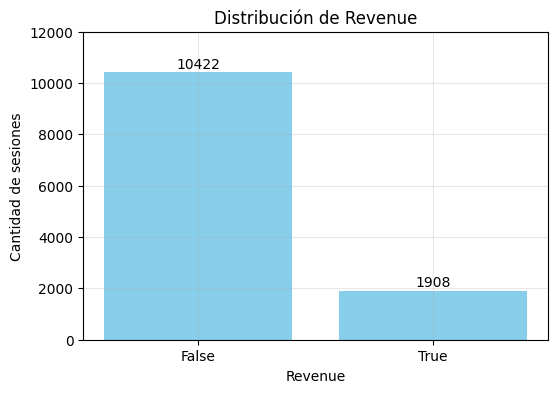



En porcentajes:
Revenue
False    84.53%
True     15.47%
Name: proportion, dtype: object


In [43]:
# Contar valores
counts = dataset_compras["Revenue"].value_counts().sort_index()

# Graficar
plt.figure(figsize=(6, 4))
bars = plt.bar(counts.index.astype(str), counts.values,color = ['skyblue'])
plt.title(f'Distribución de Revenue')
plt.ylabel('Cantidad de sesiones')
plt.xlabel("Revenue")
plt.xticks(rotation=0)
plt.ylim(0, 12000) 
# Añadir etiquetas de valor encima de las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{int(height)}', ha='center', va='bottom', fontsize=10)

plt.grid(True, alpha=0.3)
plt.show()
print("\n")
print("En porcentajes:")
porcentajes = round(dataset_compras["Revenue"].value_counts(normalize=True) * 100, 2)
print(porcentajes.astype(str) + '%')

Continuamos graficando las variables categoricas (codificadas como numericas) del dataset para concocer sus posibles valores :

- OperatingSystems

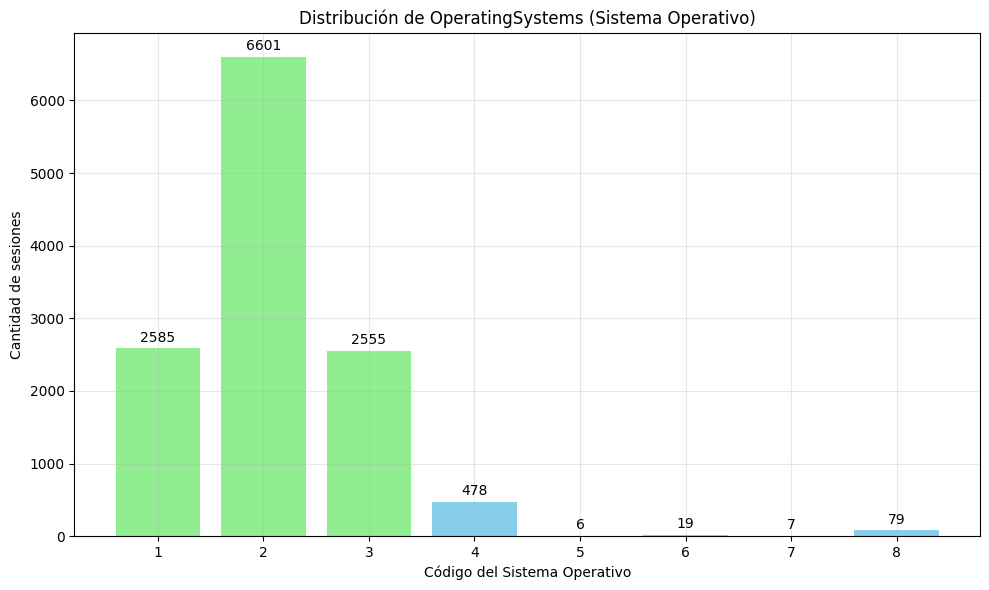

In [44]:

# Contar frecuencias
os_counts = dataset_compras['OperatingSystems'].value_counts().sort_index()

# Graficar en barras verticales
plt.figure(figsize=(10, 6))
bars = plt.bar(os_counts.index.astype(str), os_counts.values, color = ['skyblue'])
plt.title('Distribución de OperatingSystems (Sistema Operativo)')
plt.xlabel('Código del Sistema Operativo')
plt.ylabel('Cantidad de sesiones')
plt.xticks(rotation=0)

bars = plt.bar(os_counts.index.astype(str), os_counts.values, color='skyblue')
for b in bars[:3]:
    b.set_facecolor('lightgreen')

# Añadir etiquetas de valor encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{int(height)}', ha='center', va='bottom', fontsize=10)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


- TrafficType

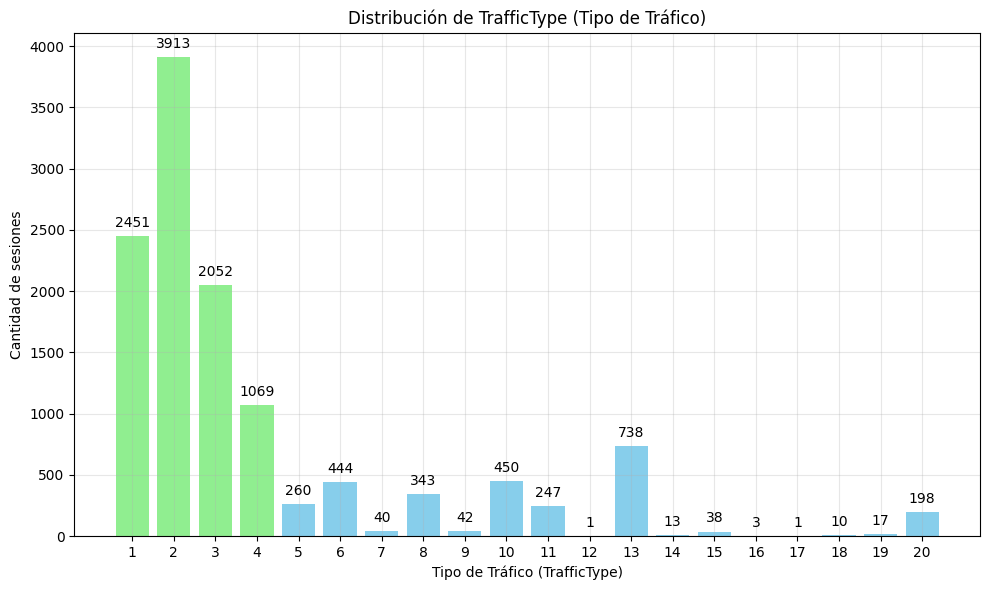

In [45]:
# Contar frecuencias
traffic_counts = dataset_compras['TrafficType'].value_counts().sort_index()

# Graficar en barras verticales
plt.figure(figsize=(10, 6))
bars = plt.bar(traffic_counts.index.astype(str), traffic_counts.values, color = ['skyblue'])
plt.title('Distribución de TrafficType (Tipo de Tráfico)')
plt.xlabel('Tipo de Tráfico (TrafficType)')
plt.ylabel('Cantidad de sesiones')
plt.xticks(rotation=0)

# pintamos las primeras 4 barras que son las mas significativas.
bars = plt.bar(traffic_counts.index.astype(str), traffic_counts.values, color='skyblue')
for b in bars[:4]:
    b.set_facecolor('lightgreen')

# Añadir etiquetas de valor encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{int(height)}', ha='center', va='bottom', fontsize=10)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


- Region

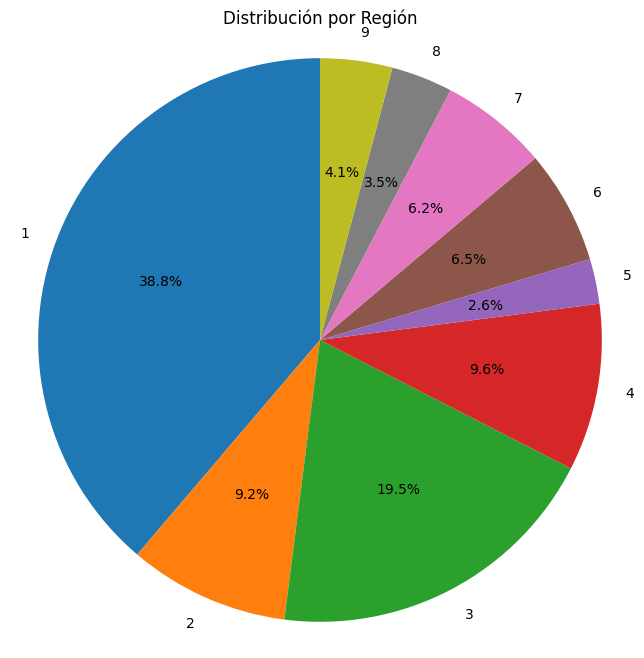

In [46]:

# Contar frecuencias
region_counts = dataset_compras['Region'].value_counts().sort_index()

# Graficar
plt.figure(figsize=(8, 8))
plt.pie(region_counts.values, labels=region_counts.index.astype(str), autopct='%1.1f%%', startangle=90)
plt.title('Distribución por Región')
plt.axis('equal') 
plt.show()


# marcar que probablemente la 1 sea turquia por el origen del dataset, y el resto zonas aledanas...

- Browser

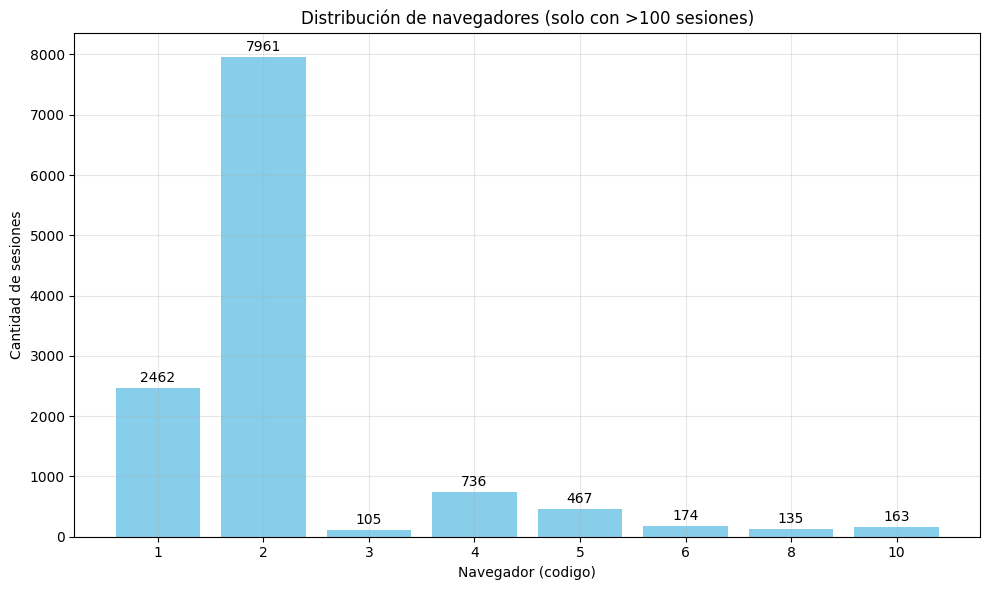

In [47]:

# Contar frecuencias
browser_counts = dataset_compras['Browser'].value_counts().sort_index()
# Filtrar solo los navegadores con más de 100 sesiones
browser_significativos = browser_counts[browser_counts > 100]

# Graficar
plt.figure(figsize=(10, 6))
bars = plt.bar(browser_significativos.index.astype(str), browser_significativos.values, color = ['skyblue'])
plt.title('Distribución de navegadores (solo con >100 sesiones)')
plt.xlabel('Navegador (codigo)')
plt.ylabel('Cantidad de sesiones')
plt.xticks(rotation=0)  # Rotación 0 para que se vean bien los números

# Añadir etiquetas de valor encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{int(height)}', ha='center', va='bottom', fontsize=10)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# explicar porque graficamos esos nomas, los "mas significativos". el resto no tiene sentido indagarlos.

- Weekend

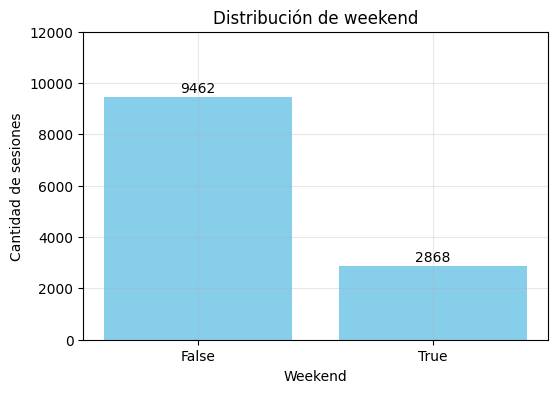



En porcentajes:
Weekend
False    76.74%
True     23.26%
Name: proportion, dtype: object


In [48]:

# Contar valores
counts = dataset_compras["Weekend"].value_counts().sort_index()

# Graficar
plt.figure(figsize=(6, 4))
bars = plt.bar(counts.index.astype(str), counts.values, color = ['skyblue'])
plt.title(f'Distribución de weekend')
plt.ylabel('Cantidad de sesiones')
plt.xlabel("Weekend")
plt.xticks(rotation=0)
plt.ylim(0, 12000) 
# Añadir etiquetas de valor encima de las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{int(height)}', ha='center', va='bottom', fontsize=10)

plt.grid(True, alpha=0.3)
plt.show()
print("\n")
print("En porcentajes:")
porcentajes = round(dataset_compras["Weekend"].value_counts(normalize=True) * 100, 2)
print(porcentajes.astype(str) + '%')

- Month

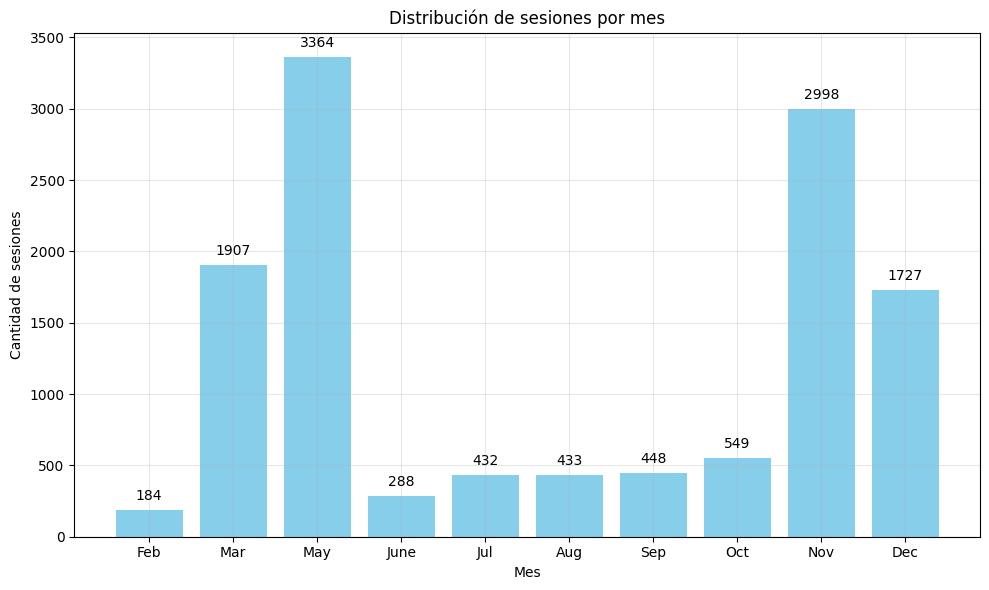

In [49]:
# Contar frecuencias por mes (ordenado como aparecen en el dataset)
month_counts = dataset_compras['Month'].value_counts().reindex([
    'Feb', 'Mar', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
], fill_value=0)

# Graficar
plt.figure(figsize=(10, 6))
bars = plt.bar(month_counts.index, month_counts.values, color = ['skyblue'])
plt.title('Distribución de sesiones por mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de sesiones')
plt.xticks(rotation=0)  # Rotación 0 para que se vean bien los nombres

# Añadir etiquetas de valor encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{int(height)}', ha='center', va='bottom', fontsize=10)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# marcar q falta abril y enero.

Luego optamos por visualizar a traves de histogramas, la distribucion (en general) de cada variable cuantitativa. Es muy importante marcar que los ultimos 4 graficos no tienen sentido, porque como ya mencionamos esas variables son categoricas (en la seccion de limpieza y pre-procesamiento se convertiran a categoricas). 

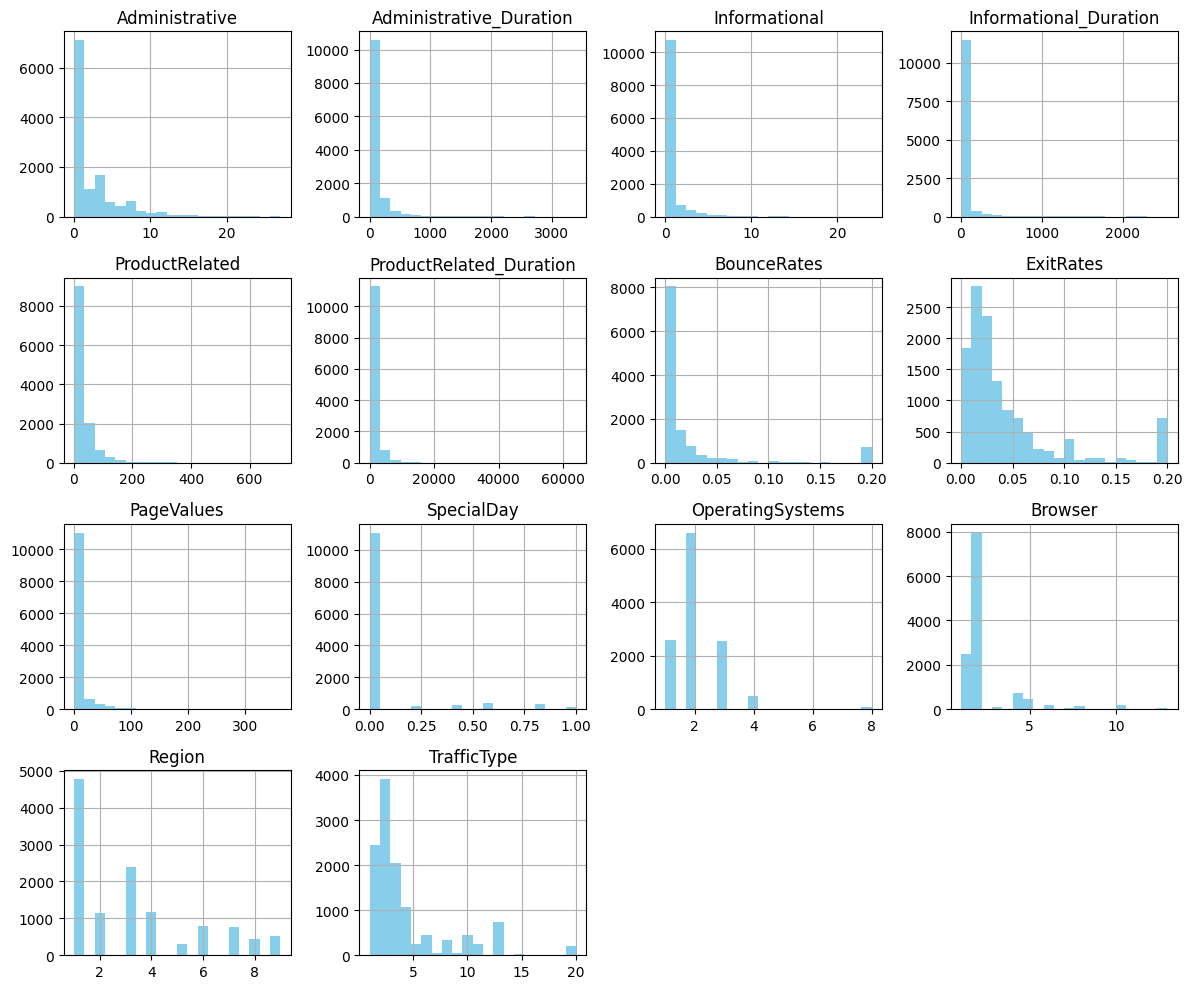

In [50]:
dataset_compras.hist(figsize=(12, 10), bins=20,color = ['skyblue'])
plt.tight_layout()
plt.show()

#### Limpieza y pre-procesamiento
- eliminacion de repetidos
- correccion de inconsistencias con imputacion de valores por media
- dos columnas booleanas cambiadas a binarias
- conversion de variables cuantitativa a categoricas (OperatingSystem, Browser, Region, TrafficType)

In [51]:
# Eliminar duplicados (exactamente los mismos valores en cada columna)
df = dataset_compras.drop_duplicates(keep='first')
print(f"Se eliminaron {len(dataset_compras) - len(df)} registros duplicados")

Se eliminaron 125 registros duplicados


In [52]:
# Conversion de cuantitativas a categoricas.
categoricas = ['OperatingSystems', 'Browser', 'Region', 'TrafficType']
for col in categoricas:
    df.loc[:, col] = df[col].astype('category')


In [53]:
df = df.copy()
    
# Imputacion de valores inconsistentes por media (ponderada luego)
for tipo_pagina in ["Administrative", "Informational", "ProductRelated"]:
    duration = f"{tipo_pagina}_Duration"

    # Identificar inconsistencias
    inconsistencias = (df[tipo_pagina] > 0) & (df[duration] == 0)
    if inconsistencias.sum() > 0: 
  
        duracion_promedio = df[
            (df[tipo_pagina] > 0) & (df[duration] > 0)
        ][duration].mean()
            
        # Para todas las filas donde inconsistencias sea True, en la columna duration, asigna el nuevo valor.
        df.loc[inconsistencias, duration] = duracion_promedio * 0.5

In [54]:
# Convertir booleanos a binarios.
df['Weekend'] = df['Weekend'].astype(int)
df['Revenue'] = df['Revenue'].astype(int)

#### PLANTEO DE HIPOTESIS : UNIVARIADAS

##### Hipotesis 1 : “La gran mayoría de las sesiones ocurren en fechas cercanas a dias festivos (SpecialDay = 0), lo que indica que el tráfico está fuertemente impulsado por las oportunidades de mercado relacionadas a estas fechas.” 

Total de sesiones: 12205
Sesiones con SpecialDay = 0: 10956
Proporción de sesiones cerca de días festivos: 89.8%

Distribución de SpecialDay:
SpecialDay
0.0    10956
0.2      178
0.4      243
0.6      350
0.8      324
1.0      154
Name: count, dtype: int64


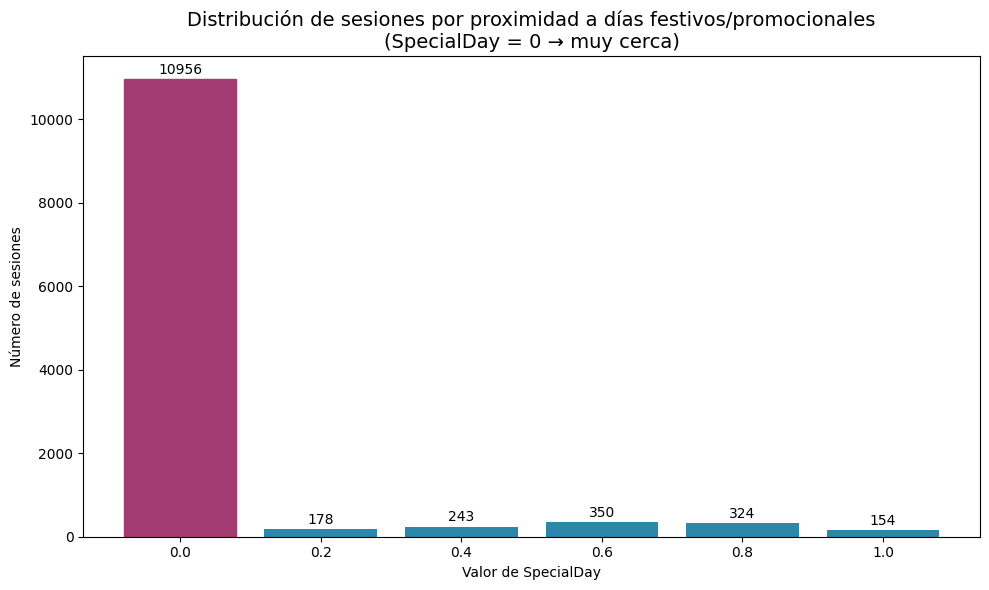

In [55]:
# Proporción de sesiones con SpecialDay = 0 (cerca de día festivo)
prop_cerca_festivo = (df['SpecialDay'] == 0).mean()
total_sesiones = len(df)
specialday_counts = df['SpecialDay'].value_counts().sort_index()
print(f"Total de sesiones: {total_sesiones}")
print(f"Sesiones con SpecialDay = 0: {(df['SpecialDay'] == 0).sum()}")
print(f"Proporción de sesiones cerca de días festivos: {prop_cerca_festivo:.1%}")

print("\nDistribución de SpecialDay:")
print(df['SpecialDay'].value_counts().sort_index())


# 3. Crear gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(specialday_counts.index.astype(str), specialday_counts.values, color='#2E86AB')
plt.title('Distribución de sesiones por proximidad a días festivos/promocionales\n(SpecialDay = 0 → muy cerca)', fontsize=14)
plt.xlabel('Valor de SpecialDay')
plt.ylabel('Número de sesiones')
plt.xticks(rotation=0)

# Añadir etiquetas de valor encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{int(height)}', ha='center', va='bottom', fontsize=10)

# Resaltar la barra de SpecialDay = 0
bars[0].set_color('#A23B72')

plt.tight_layout()
plt.show()


##### Hipotesis 2 : "La mayoría de las compras están asociadas a sesiones de usuarios que ya visitaron el sitio y tienen experiencia previa, lo cual se evidencia al observar que los 'Returning_Visitor' representan la cantidad más alta de transacciones en comparación con 'New_Visitor' y 'Other'."

A nuestra interpretacion, las campanas de marketing para nuevos clientes funcionan atrayendo trafico, pero no ayudan a compras durante la primera visita a la pagina.



🛒 COMPRAS REALIZADAS POR TIPO DE VISITANTE
• Returning_Visitor: 1470 compras (77.0%)
• New_Visitor: 422 compras (22.1%)
• Other: 16 compras (0.8%)

📊 TOTAL: 1908 compras analizadas


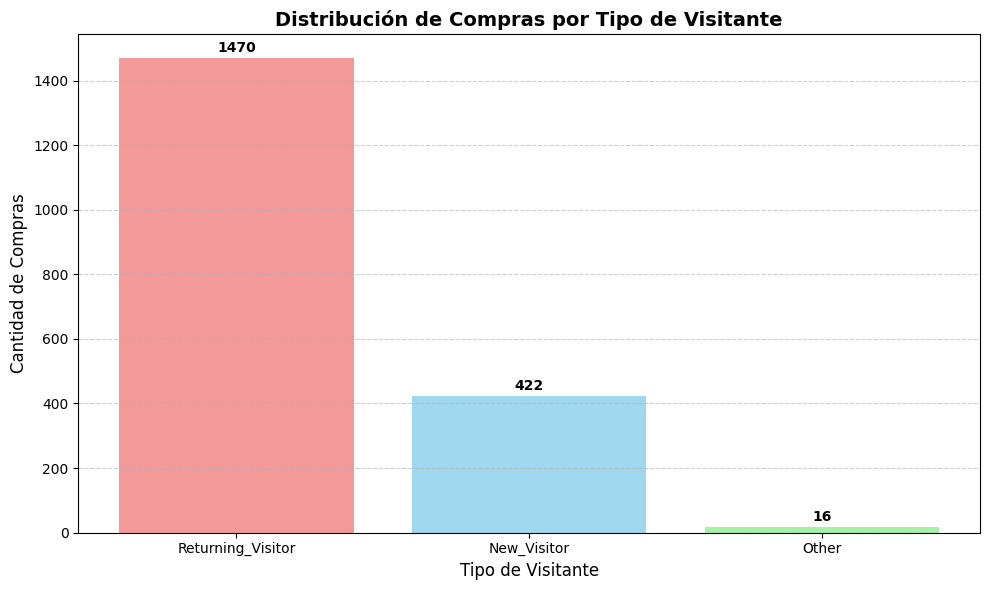

In [56]:
# 1. Filtrar solo las sesiones que resultaron en compra
compras_df = df[df['Revenue'] == True]

# 2. Contar las compras por tipo de visitante
compras_por_tipo = compras_df['VisitorType'].value_counts()
total_compras = len(compras_df)

print("🛒 COMPRAS REALIZADAS POR TIPO DE VISITANTE")
print("="*60)

# 3. Imprimir los resultados
for tipo, cantidad in compras_por_tipo.items():
    porcentaje = (cantidad / total_compras) * 100
    print(f"• {tipo}: {cantidad} compras ({porcentaje:.1f}%)")

print(f"\n📊 TOTAL: {total_compras} compras analizadas")

# 4. Crear el gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(compras_por_tipo.index, compras_por_tipo.values, color=['lightcoral', 'skyblue', 'lightgreen'], alpha=0.8)

# Agregar etiquetas de valor
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height + 10,
             f'{int(height)}',
             ha='center', va='bottom',
             fontweight='bold')

plt.title('Distribución de Compras por Tipo de Visitante', fontsize=14, fontweight='bold')
plt.xlabel('Tipo de Visitante', fontsize=12)
plt.ylabel('Cantidad de Compras', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


#### PLANTEO DE HIPOTESIS : BIVARIADAS

##### Hipótesis 3 : El ultimo trimestre del anio es donde se registran mas sesiones finalizadas en compra.

hay que hacer test! es bivariada.

Hacemos un test para comprobar la hipotesis.


COMPRAS POR TRIMESTRE:
Ene-Mar: 195 compras (10.4%)
Abr-Jun: 365 compras (19.4%)
Jul-Sep: 228 compras (12.1%)
Oct-Dic: 1091 compras (58.1%)


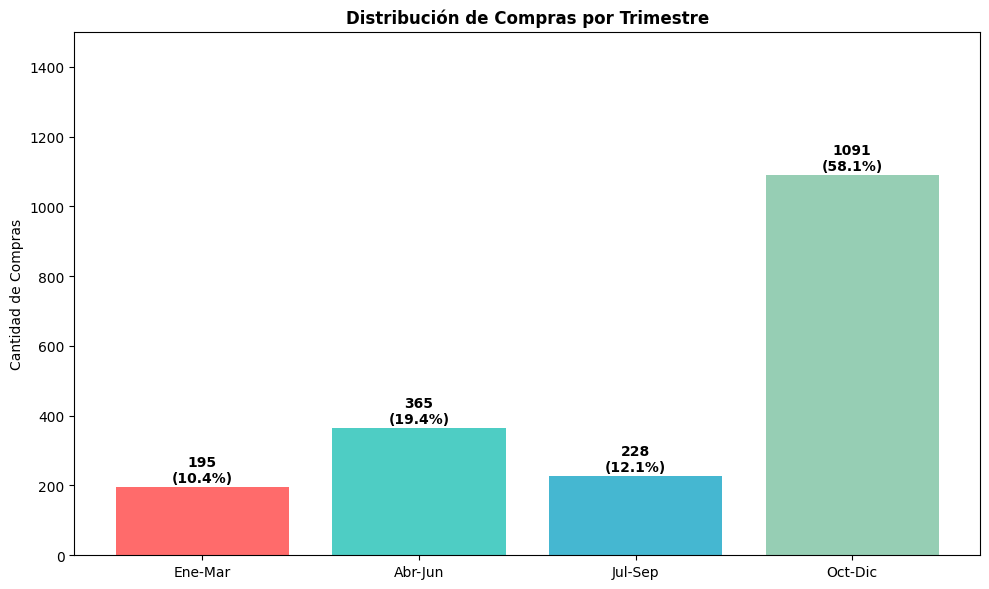


DEFINICIÓN DE HIPÓTESIS:
Hipótesis NULA : Los 4 trimestres tienen igual cantidad de compras
Hipótesis ALTERNATIVA : Oct-Dic tiene MÁS compras

TEST CHI-CUADRADO:
Estadístico: 1130.0793
p-value: 0.000000
Nivel de significancia (α): 0.05

CONCLUSIÓN:
Se RECHAZA la hipótesis nula
Existen diferencias significativas entre trimestres
TU HIPÓTESIS ALTERNATIVA SE CONFIRMA
Oct-Dic tiene SIGNIFICATIVAMENTE más compras
Representa el 58.1% vs 25% esperado

EVIDENCIA ADICIONAL:
Oct-Dic: 58.1% (esperado: 25%)
Diferencia: +33.1 puntos porcentuales
Ventaja sobre promedio: +132.4%
Ventaja sobre segundo: +726 compras


In [ ]:
# 1. Definir trimestres
trimestre_map = {
    'Jan': 'Ene-Mar', 'Feb': 'Ene-Mar', 'Mar': 'Ene-Mar',
    'Apr': 'Abr-Jun', 'May': 'Abr-Jun', 'Jun': 'Abr-Jun', 
    'Jul': 'Jul-Sep', 'Aug': 'Jul-Sep', 'Sep': 'Jul-Sep',
    'Oct': 'Oct-Dic', 'Nov': 'Oct-Dic', 'Dec': 'Oct-Dic'
}

# 2. Agrupar compras por trimestre
compras_trimestre = df[df['Revenue'] == True]['Month'].map(trimestre_map).value_counts().reindex(['Ene-Mar', 'Abr-Jun', 'Jul-Sep', 'Oct-Dic'])
porcentajes = (compras_trimestre / compras_trimestre.sum() * 100).round(1)

print("COMPRAS POR TRIMESTRE:")
for trim, compras in compras_trimestre.items():
    print(f"{trim}: {compras} compras ({porcentajes[trim]}%)")

# 3. Gráfico
plt.figure(figsize=(10, 6))
bars = plt.bar(compras_trimestre.index, compras_trimestre.values, color=['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4'])
plt.title('Distribución de Compras por Trimestre', fontweight='bold')
plt.ylabel('Cantidad de Compras')
plt.ylim(0, 1500)

for bar, valor, porcentaje in zip(bars, compras_trimestre.values, porcentajes.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             f'{valor}\n({porcentaje}%)', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

# 4. DEFINICIÓN CORRECTA DE HIPÓTESIS
print(f"\nDEFINICIÓN DE HIPÓTESIS:")
print("="*40)
print("Hipótesis NULA : Los 4 trimestres tienen igual cantidad de compras")
print("Hipótesis ALTERNATIVA : Oct-Dic tiene MÁS compras")

# 5. TEST CHI-CUADRADO DE BONDAD DE AJUSTE
print(f"\nTEST CHI-CUADRADO:")
print("="*30)

# Esperado: distribución uniforme (25% cada trimestre)
esperado = [compras_trimestre.sum() / 4] * 4
observado = compras_trimestre.values

chi2, p_value = stats.chisquare(observado, esperado)

print(f"Estadístico: {chi2:.4f}")
print(f"p-value: {p_value:.6f}")
print(f"Nivel de significancia (α): 0.05")

# 6. CONCLUSIÓN CORRECTA
print(f"\nCONCLUSIÓN:")
if p_value < 0.05:
    print("Se RECHAZA la hipótesis nula")
    print("Existen diferencias significativas entre trimestres")
    
    # Verificar si Oct-Dic es el mayor
    if compras_trimestre.idxmax() == 'Oct-Dic':
        print("TU HIPÓTESIS ALTERNATIVA SE CONFIRMA")
        print("Oct-Dic tiene SIGNIFICATIVAMENTE más compras")
        print(f"Representa el {porcentajes['Oct-Dic']}% vs 25% esperado")
    else:
        print(f"Tu hipótesis NO se confirma")
        print(f"{compras_trimestre.idxmax()} tiene más compras, no Oct-Dic")
else:
    print("NO se rechaza la hipótesis nula")
    print("No hay diferencias significativas entre trimestres")
    print("Las compras se distribuyen uniformemente")

# 7. EVIDENCIA ADICIONAL
print(f"\nEVIDENCIA ADICIONAL:")
oct_dic_porcentaje = porcentajes['Oct-Dic']
diferencia_vs_esperado = oct_dic_porcentaje - 25

print(f"Oct-Dic: {oct_dic_porcentaje}% (esperado: 25%)")
print(f"Diferencia: {diferencia_vs_esperado:+.1f} puntos porcentuales")
print(f"Ventaja sobre promedio: {(oct_dic_porcentaje/25 - 1)*100:+.1f}%")

if compras_trimestre.idxmax() == 'Oct-Dic':
    segundo = compras_trimestre.nlargest(2).iloc[1]
    ventaja = compras_trimestre['Oct-Dic'] - segundo
    print(f"Ventaja sobre segundo: +{ventaja} compras")

Para esta hipótesis, elegimos el test de Chi-cuadrado (no-parametrico) porque es la herramienta correcta para comparar conteos en diferentes categorías, que en nuestro caso son los cuatro trimestres. Queríamos ver si la cantidad de compras que observamos en cada trimestre se desviaba de una distribución uniforme (es decir, si todos los trimestres tuvieran la misma cantidad de compras). El test nos permite determinar si el mayor número de compras en el último trimestre es una diferencia real y estadísticamente significativa, o si es solo una variación por azar.

##### Hipotesis 4: "Entre las sesiones que resultaron en compra, y un alto valor de PageValues se corresponde con que se visitaron muchas paginas o hubo una exploracion profunda del sitio"

Las sesiones de compra valiosas (alto PageValues) se caracterizan por una exploracion profunda del sitio (valor alto de ProductRelated)




Correlación (Pearson) entre PageValues y ProductRelated (solo compras): -0.1778

--- Parte 1: Correlación de Spearman (Mide relación monótona) ---
Correlación Spearman (PageValues vs ProductRelated): -0.2089

--- Parte 2: Análisis con PageValues como variable Cualitativa (Box Plots) ---


Text(0, 0.5, 'Páginas de Producto Visitadas')

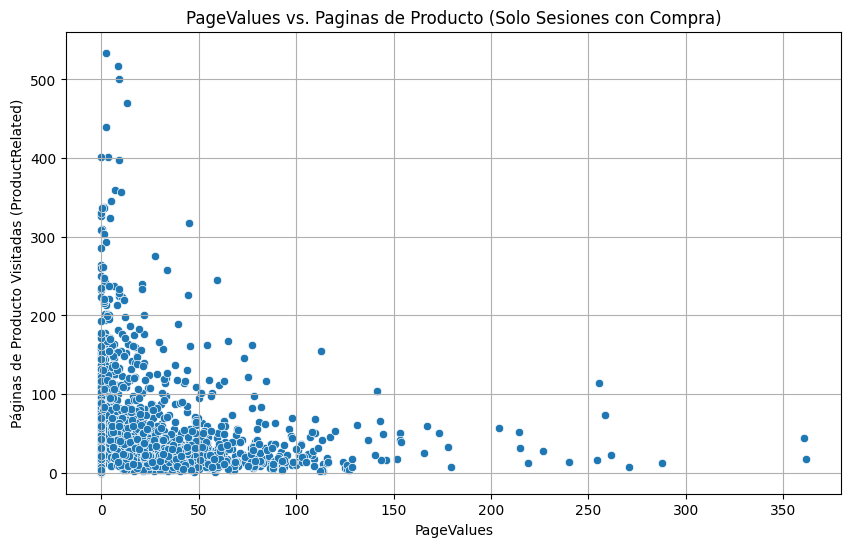

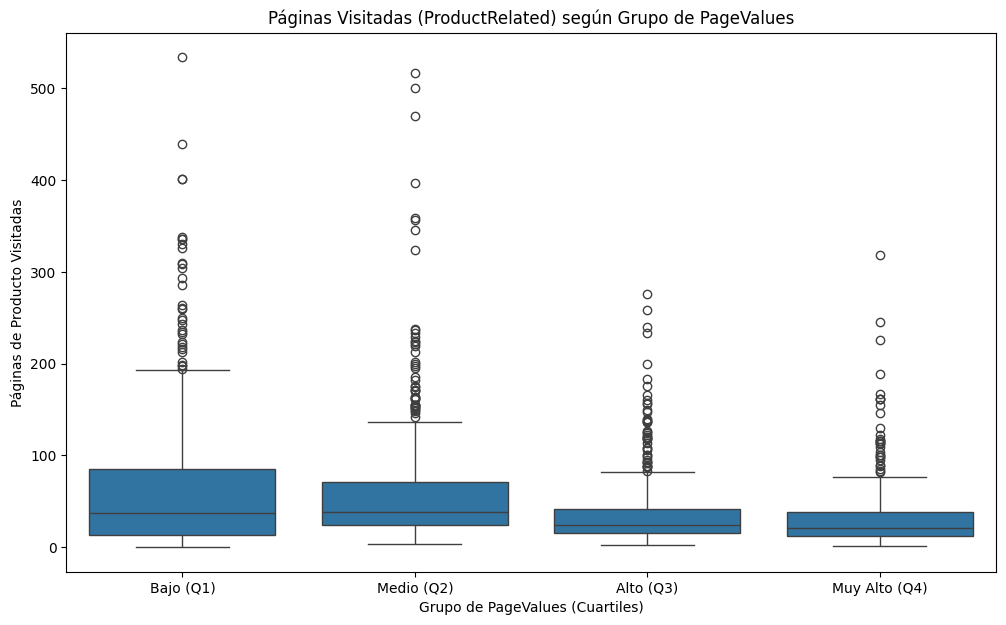

In [ ]:
df_compra = df[df['Revenue'] == 1].copy()

correlacion = df_compra["PageValues"].corr(df_compra["ProductRelated"])
print(f"Correlación (Pearson) entre PageValues y ProductRelated (solo compras): {correlacion:.4f}")

# Creamos el gráfico de dispersión (visto en Práctica 5)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_compra, x='PageValues', y='ProductRelated')
plt.title('PageValues vs. Paginas de Producto (Solo Sesiones con Compra)')
plt.xlabel('PageValues')
plt.ylabel('Páginas de Producto Visitadas (ProductRelated)')
plt.grid(True)


# --- PARTE 1: CORRELACIÓN DE SPEARMAN ---
print("\n--- Parte 1: Correlación de Spearman (Mide relación monótona) ---")

    # Correlación Spearman: PageValues vs. ProductRelated (Páginas)
corr_paginas_s = df_compra['PageValues'].corr(
    df_compra['ProductRelated'], 
    method='spearman'
)
print(f"Correlación Spearman (PageValues vs ProductRelated): {corr_paginas_s:.4f}")


# --- PARTE 2: BOX PLOTS (CON PAGEVALUES CUALITATIVA) ---
print("\n--- Parte 2: Análisis con PageValues como variable Cualitativa (Box Plots) ---")

# Discretizamos PageValues en 4 cuartiles
df_compra['PageValues_Grupo'] = pd.qcut(
    df_compra['PageValues'], 
    q=4, 
    labels=['Bajo (Q1)', 'Medio (Q2)', 'Alto (Q3)', 'Muy Alto (Q4)']
)
    
# Gráfico 1: Box Plot (PageValues Grupo vs. ProductRelated)
plt.figure(figsize=(12, 7))
sns.boxplot(
    data=df_compra, 
    x='PageValues_Grupo', 
    y='ProductRelated', 
    order=['Bajo (Q1)', 'Medio (Q2)', 'Alto (Q3)', 'Muy Alto (Q4)']
)
plt.title('Páginas Visitadas (ProductRelated) según Grupo de PageValues')
plt.xlabel('Grupo de PageValues (Cuartiles)')
plt.ylabel('Páginas de Producto Visitadas')



La hipótesis NO se cumple.

¿Por qué?

Los datos muestran que las sesiones con mayor valor de PageValues (las más valiosas) NO son las que visitaron más páginas de producto.

En el gráfico de dispersión, ves que los puntos con PageValues altos (hacia la derecha) están en su mayoría en la parte baja del eje vertical (pocas páginas visitadas).
El boxplot confirma que, en promedio, los grupos con PageValues "Alto" y "Muy Alto" tienen menos páginas visitadas que los grupos "Bajo" y "Medio".
En otras palabras:

No es necesario visitar muchas páginas para generar un alto valor.
Muchas compras valiosas (alta PageValues) ocurren después de una navegación rápida o focalizada, no tras una exploración larga. 

“No necesitamos que los usuarios naveguen mucho para comprar. De hecho, las compras más valiosas a menudo vienen de quienes encuentran rápido lo que buscan. Nuestro sitio debe enfocarse en hacer que la experiencia sea rápida y directa, no en hacer que la gente ‘exploré’ más.”

##### Hipotesis 5: "El tiempo promedio de las sesiones en paginas administrativas (inicios de sesion, configuracion,proceso de pago, etc) es el mismo para sesiones que terminan en compra y sesiones que no resultan en compra"

Se sospecha que si una sesion pasa un tiempo excesivo en secciones Administrativas y ademas la sesion no termina en compra, quiza porque el usuario esta "atascado" (friccion operativa)

In [ ]:
from scipy import stats

# Separar los datos en dos grupos
grupo_no_compra = df[df['Revenue'] == False]['Administrative_Duration']
grupo_compra = df[df['Revenue'] == True]['Administrative_Duration']

print("📊 TEST DE MANN-WHITNEY U - ADMINISTRATIVE_DURATION")
print("="*60)

# Estadísticas descriptivas
print("🔹 ESTADÍSTICAS DESCRIPTIVAS:")
print(f"   NO COMPRARON (n={len(grupo_no_compra)}):")
print(f"      • Media: {grupo_no_compra.mean():.2f} segundos")
print(f"      • Mediana: {grupo_no_compra.median():.2f} segundos")
print(f"      • Desviación: {grupo_no_compra.std():.2f} segundos")

print(f"\n   COMPRARON (n={len(grupo_compra)}):")
print(f"      • Media: {grupo_compra.mean():.2f} segundos")
print(f"      • Mediana: {grupo_compra.median():.2f} segundos")
print(f"      • Desviación: {grupo_compra.std():.2f} segundos")

# Realizar el test de Mann-Whitney U
stat, p_value = stats.mannwhitneyu(grupo_no_compra, grupo_compra, alternative='two-sided')

print(f"\n🎯 RESULTADO DEL TEST MANN-WHITNEY U:")
print(f"   • Estadístico U: {stat:.2f}")
print(f"   • p-value: {p_value:.6f}")
print(f"   • Nivel de significancia (α): 0.05")

print(f"\n📈 INTERPRETACIÓN:")
print(f"   • Hipótesis Nula (H₀): El tiempo en páginas administrativas es igual en ambos grupos")
print(f"   • Hipótesis Alternativa (H₁): El tiempo en páginas administrativas es diferente")

if p_value < 0.05:
    print(f"   • ✅ Se RECHAZA la hipótesis nula (p < 0.05)")
    print(f"   • 📊 Existe diferencia estadísticamente significativa")
    if grupo_compra.median() > grupo_no_compra.median():
        print(f"   • ⬆️  Las sesiones que COMPRAN pasan MÁS tiempo en páginas administrativas")
    else:
        print(f"   • ⬇️  Las sesiones que COMPRAN pasan MENOS tiempo en páginas administrativas")
else:
    print(f"   • ❌ NO se rechaza la hipótesis nula (p ≥ 0.05)")
    print(f"   • 📊 NO existe diferencia estadísticamente significativa")
    print(f"   • El tiempo en páginas administrativas es similar en ambos grupos")

print(f"\n💡 CONCLUSIÓN FINAL:")
if p_value < 0.05:
    print("   La evidencia sugiere que el tiempo en páginas administrativas")
    print("   influye en la decisión de compra del usuario")
else:
    print("   No hay evidencia suficiente para afirmar que el tiempo en")
    print("   páginas administrativas afecta la decisión de compra")

📊 TEST DE MANN-WHITNEY U - ADMINISTRATIVE_DURATION
🔹 ESTADÍSTICAS DESCRIPTIVAS:
   NO COMPRARON (n=10297):
      • Media: 75.40 segundos
      • Mediana: 3.00 segundos
      • Desviación: 171.70 segundos

   COMPRARON (n=1908):
      • Media: 120.86 segundos
      • Mediana: 56.80 segundos
      • Desviación: 200.55 segundos

🎯 RESULTADO DEL TEST MANN-WHITNEY U:
   • Estadístico U: 7372637.00
   • p-value: 0.000000
   • Nivel de significancia (α): 0.05

📈 INTERPRETACIÓN:
   • Hipótesis Nula (H₀): El tiempo en páginas administrativas es igual en ambos grupos
   • Hipótesis Alternativa (H₁): El tiempo en páginas administrativas es diferente
   • ✅ Se RECHAZA la hipótesis nula (p < 0.05)
   • 📊 Existe diferencia estadísticamente significativa
   • ⬆️  Las sesiones que COMPRAN pasan MÁS tiempo en páginas administrativas

💡 CONCLUSIÓN FINAL:
   La evidencia sugiere que el tiempo en páginas administrativas
   influye en la decisión de compra del usuario


La hipótesis buscaba comparar la media de la variable cuantitativa Administrative_Duration entre dos grupos independientes (sesiones con Revenue=True y Revenue=False). El test paramétrico ideal es el Test t de Student.

Sin embargo, para usar el Test t, se debe cumplir el supuesto de Normalidad. Como se observó en el análisis univariado y se confirmó mediante el test de Shapiro-Wilk (p-value < 0.05), la variable Administrative_Duration no sigue una distribución normal; presenta un fuerte sesgo.

Al no cumplirse el supuesto de normalidad, se descartó el Test t y se procedió a utilizar su alternativa no paramétrica: el Test de Mann-Whitney U

Se plantearon las siguientes hipótesis:
Hipótesis Nula ($H_0$): El tiempo promedio en páginas administrativas es igual en ambos grupos.
Hipótesis Alternativa ($H_a$): El tiempo promedio en páginas administrativas es diferente entre los grupos.
Se utilizó un nivel de significancia (alfa) de 0.05.
El resultado del Test de Mann-Whitney U arrojó un $p$-value < 0.05. Dado que el $p$-value es menor que nuestro alfa, la evidencia estadística es suficiente para rechazar la Hipótesis Nula ($H_0$).

Se demuestra que existe una diferencia estadísticamente significativa en el tiempo que las sesiones pasan en páginas administrativas (Administrative_Duration) entre aquellas que terminan en compra y aquellas que no.




In [ ]:
# Usamos la Mediana porque la distribución no es normal
print(f"Mediana de 'Administrative_Duration' (Compra): {grupo_compra.median():.2f} segundos")
print(f"Mediana de 'Administrative_Duration' (No Compra): {grupo_no_compra.median():.2f} segundos")

# También mostramos la Media para contexto
print(f"\nMedia de 'Administrative_Duration' (Compra): {grupo_compra.mean():.2f} segundos")
print(f"Media de 'Administrative_Duration' (No Compra): {grupo_no_compra.mean():.2f} segundos")

Mediana de 'Administrative_Duration' (Compra): 56.80 segundos
Mediana de 'Administrative_Duration' (No Compra): 3.00 segundos

Media de 'Administrative_Duration' (Compra): 120.86 segundos
Media de 'Administrative_Duration' (No Compra): 75.40 segundos


Se demuestra que existe una diferencia estadísticamente significativa... Específicamente, se observa que las sesiones que terminan en compra pasan, en promedio, más tiempo en páginas administrativas que aquellas que no compran. Esto suponemos que se debe a que las sesiones que compran, tienen que pasar por mas tramos administrativos, como inicios de sesion, registro de tarjetas de pago, confirmaciones de compra, etc"

#### Analisis Multivariado:

Comenzamos el analisis realizando un tSNE...(explicar)

In [ ]:
"""from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(df.select_dtypes(include=['number']))

# Mapear VisitorType a colores
visitortype_map = {'New_Visitor': 0, 'Returning_Visitor': 1, 'Other': 2}
colors = np.array([visitortype_map.get(str(typ), 3) for typ in df['VisitorType']])

# Graficar
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors, alpha=0.7, s=30, cmap='Set1')

# Leyenda
legend_labels = ['New_Visitor', 'Returning_Visitor', 'Other']
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Tipo de Visitante')

plt.title('t-SNE - Coloreado por Tipo de Visitante')
plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')
plt.show()"""

"from sklearn.manifold import TSNE\nimport matplotlib.pyplot as plt\n\ntsne = TSNE(n_components=2, random_state=42, perplexity=30)\nX_tsne = tsne.fit_transform(df.select_dtypes(include=['number']))\n\n# Mapear VisitorType a colores\nvisitortype_map = {'New_Visitor': 0, 'Returning_Visitor': 1, 'Other': 2}\ncolors = np.array([visitortype_map.get(str(typ), 3) for typ in df['VisitorType']])\n\n# Graficar\nplt.figure(figsize=(12, 8))\nscatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors, alpha=0.7, s=30, cmap='Set1')\n\n# Leyenda\nlegend_labels = ['New_Visitor', 'Returning_Visitor', 'Other']\nplt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Tipo de Visitante')\n\nplt.title('t-SNE - Coloreado por Tipo de Visitante')\nplt.xlabel('Componente t-SNE 1')\nplt.ylabel('Componente t-SNE 2')\nplt.show()"

In [ ]:
"""import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df_numeric = df.select_dtypes(include=['number'])

# estandarizamos X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

print(np.mean(X_scaled, axis=0))
print(np.std(X_scaled, axis=0))


# Ahora aplicamos PCA a los datos estandarizados
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
# graficamos los datos
plt.scatter(X_pca[:,0], X_pca[:,1])
plt.grid(True)
plt.xlabel('Proyección PCA 1')
plt.ylabel('Proyección PCA 2')
plt.title('Proyección del conjunto de datos a 2 dimensiones')
plt.show()"""

"import numpy as np\n\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.decomposition import PCA\n\ndf_numeric = df.select_dtypes(include=['number'])\n\n# estandarizamos X\nscaler = StandardScaler()\nX_scaled = scaler.fit_transform(df_numeric)\n\nprint(np.mean(X_scaled, axis=0))\nprint(np.std(X_scaled, axis=0))\n\n\n# Ahora aplicamos PCA a los datos estandarizados\npca = PCA(n_components=2)\nX_pca = pca.fit_transform(X_scaled)\n# graficamos los datos\nplt.scatter(X_pca[:,0], X_pca[:,1])\nplt.grid(True)\nplt.xlabel('Proyección PCA 1')\nplt.ylabel('Proyección PCA 2')\nplt.title('Proyección del conjunto de datos a 2 dimensiones')\nplt.show()"

##### Hipotesis 6: "Existen perfiles de compradores definidos o los compradores se comportan de manera similar"

La hipótesis nula (H0) es que no existen grupos diferenciados y que todas las sesiones de compradores provienen de una única distribución. 
La hipótesis alternativa (H1) es que existen 3 grupos en el dataset que estan definidos por un perfil/tipo de comprador.

Los perfiles de compradores son:
1. Perfil Explorador: Se caracteriza por un valor mas alto en 'ProductRelated_Duration', que en 'Administrative_Duration' e 'Informational_Duration'.
2. Perfil Nuevo o Desconfiado: Se caracteriza por valores mas altos en 'Informational_Duration' y 'Administrative_Duration', que en 'ProductRelated_Duration'.
3. Perfil Directo: Se caracteriza por un valor mas alto en 'Administrative_Duration', comparado con los valores en 'ProductRelated_Duration' e 'Informational_Duration'.







In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Seleccionamos las columnas numéricas para la normalización
numeric_cols = df.select_dtypes(include=np.number).columns

# Creamos un objeto MinMaxScaler
scaler = MinMaxScaler()

# Ajustamos el scaler a los datos y transformamos los datos
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Imprimimos el DataFrame con los datos normalizados
df.head()

from sklearn.cluster import KMeans

# Separamos las features de las variables de duración
features = ['Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration']
X = df[df['Revenue'] == True][features]


# Inicializamos KMeans con 3 clusters según tu hipótesis
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
# Aplicamos sobre nuestros datos para hallar los centroides
kmeans.fit(X)
# Obtenemos los clusters a los que fueron asignadas las sesiones
clusters_kmeans = kmeans.predict(X)

# Creamos un DataFrame con las features y los clusters asignados
cluster_df = X.copy()
cluster_df['Cluster'] = clusters_kmeans


# Imprimimos las sesiones de cada cluster
for cluster_num in range(3):
    print(f"\nCluster {cluster_num}:")
    print(f"Sesiones: {len(cluster_df[cluster_df['Cluster'] == cluster_num])}")
    # Mostramos las características promedio de cada cluster
    print("Características promedio:")
    print(cluster_df[cluster_df['Cluster'] == cluster_num][features].mean())


Cluster 0:
Sesiones: 1681
Características promedio:
Administrative_Duration    0.020515
Informational_Duration     0.010456
ProductRelated_Duration    0.025056
dtype: float64

Cluster 1:
Sesiones: 68
Características promedio:
Administrative_Duration    0.080659
Informational_Duration     0.312545
ProductRelated_Duration    0.072644
dtype: float64

Cluster 2:
Sesiones: 159
Características promedio:
Administrative_Duration    0.175355
Informational_Duration     0.037436
ProductRelated_Duration    0.056405
dtype: float64


Cluster 0:
ProductRelated_Duration (0.025) es el valor más alto de los tres.
Conclusión: Este cluster se alinea perfectamente con "Perfil Explorador", ya que son los usuarios que, en promedio, pasan más tiempo en páginas de productos.

Cluster 1:
Informational_Duration (0.312) es drásticamente más alto que los otros dos.
Conclusión: Este cluster representa a "Perfil Nuevo o Desconfiado". Son usuarios que pasan mucho tiempo en páginas informativas, probablemente buscando información, ayuda o validando la confianza del sitio antes de comprar.

Cluster 2:
Administrative_Duration (0.175) es notablemente el valor más alto.
Conclusión: Este cluster encaja con "Perfil Directo". Son usuarios que pasan la mayor parte de su tiempo en tareas administrativas, como iniciar sesión, configurar la cuenta o, más probablemente, en el proceso de pago.

Interpretamos que los resultados del clustering respaldan fuertemente la hipotesis planteada, el algoritmo K-Means encontro los 3 grupos que se corresponden con los teorizados. Sin embargo, aunque la interpretacion es clara, hay que darle un rigor estadistico para confirmar que las diferencias entre los promedios son estadisticamente significativas.

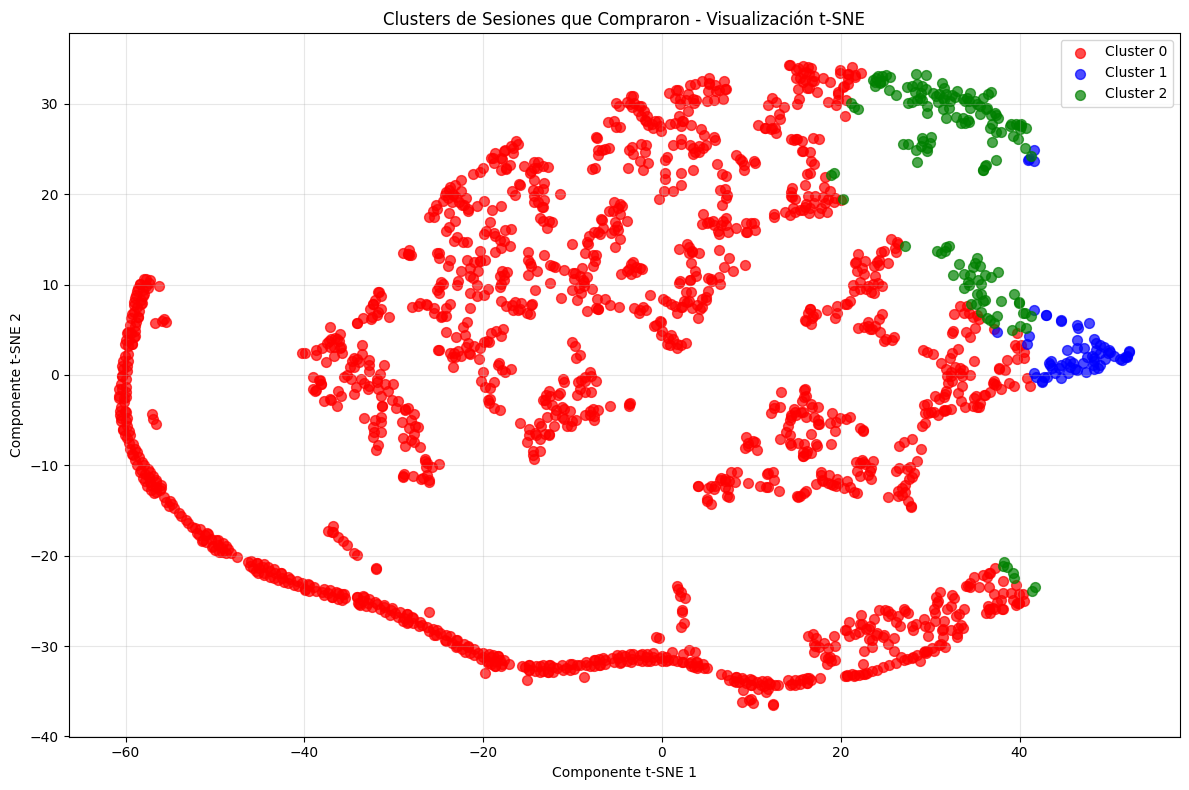

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Reducir la dimensionalidad de los datos usando t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(X)  # X ya contiene solo Revenue=True

# Crear un DataFrame con los resultados de t-SNE y los clusters
tsne_df = pd.DataFrame({
    'x': tsne_results[:, 0], 
    'y': tsne_results[:, 1], 
    'Cluster': clusters_kmeans,
    'Session': df[df['Revenue'] == True].index
})

# Graficar los resultados de t-SNE, coloreando los puntos según el cluster
plt.figure(figsize=(12, 8))
colors = ['red', 'blue', 'green']  # 3 colores para 3 clusters

for cluster_num in range(3):
    cluster_data = tsne_df[tsne_df['Cluster'] == cluster_num]
    plt.scatter(cluster_data['x'], cluster_data['y'], 
                color=colors[cluster_num], 
                label=f'Cluster {cluster_num}',
                alpha=0.7,
                s=50)

plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')
plt.title('Clusters de Sesiones que Compraron - Visualización t-SNE')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
import scipy.stats as stats

# El DataFrame 'cluster_df' ya contiene las features y la columna 'Cluster'

# Lista de características para analizar
features_to_test = ['Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration']
alpha = 0.05

for feature in features_to_test:
    print(f"--- Análisis para: {feature} ---")
    
    # Hipótesis
    print("Hipótesis Nula (H0): Las medias de la duración son iguales en los tres clusters.")
    print("Hipótesis Alternativa (H1): Al menos una de las medias de la duración es diferente.")
    print("-" * 30)

    # Extraer los datos de cada cluster para la feature actual
    cluster0 = cluster_df[cluster_df['Cluster'] == 0][feature]
    cluster1 = cluster_df[cluster_df['Cluster'] == 1][feature]
    cluster2 = cluster_df[cluster_df['Cluster'] == 2][feature]

    # Realizar el test ANOVA
    f_statistic, p_value = stats.f_oneway(cluster0, cluster1, cluster2)

    # Imprimir resultados
    print(f"Estadístico F: {f_statistic:.4f}")
    print(f"P-value: {p_value}")

    # Conclusión
    if p_value < alpha:
        print(f"Conclusión: Se rechaza la hipótesis nula (p < {alpha}).")
        print("Existe una diferencia estadísticamente significativa en las medias de los grupos.")
    else:
        print(f"Conclusión: No se puede rechazar la hipótesis nula (p >= {alpha}).")
        print("No hay evidencia de una diferencia significativa en las medias de los grupos.")
    
    print("\n")

--- Análisis para: Administrative_Duration ---
Hipótesis Nula (H0): Las medias de la duración son iguales en los tres clusters.
Hipótesis Alternativa (H1): Al menos una de las medias de la duración es diferente.
------------------------------
Estadístico F: 1145.9313
P-value: 0.0
Conclusión: Se rechaza la hipótesis nula (p < 0.05).
Existe una diferencia estadísticamente significativa en las medias de los grupos.


--- Análisis para: Informational_Duration ---
Hipótesis Nula (H0): Las medias de la duración son iguales en los tres clusters.
Hipótesis Alternativa (H1): Al menos una de las medias de la duración es diferente.
------------------------------
Estadístico F: 2176.5187
P-value: 0.0
Conclusión: Se rechaza la hipótesis nula (p < 0.05).
Existe una diferencia estadísticamente significativa en las medias de los grupos.


--- Análisis para: ProductRelated_Duration ---
Hipótesis Nula (H0): Las medias de la duración son iguales en los tres clusters.
Hipótesis Alternativa (H1): Al menos 

Validación Estadística de los Clusters con ANOVA

Para confirmar que los perfiles de usuario (clusters) que hemos identificado son genuinamente distintos, realizamos un **Análisis de Varianza (ANOVA)**. Este test nos permite determinar si las diferencias observadas en las duraciones promedio en paginas (`Administrative`, `Informational`, `ProductRelated`) entre los tres clusters son estadísticamente significativas o si podrían deberse al azar.

Para cada una de las tres variables de duración, planteamos las siguientes hipótesis:

*   **Hipótesis Nula ($H_0$)**: Las medias de la duración son iguales en los tres clusters. No hay diferencia real entre los grupos.
*   **Hipótesis Alternativa ($H_1$)**: Al menos una de las medias de la duración es diferente. Los grupos no se comportan de la misma manera.

El **p-value** obtenido en el test es menor que nuestro nivel de significancia (alpha 0.05), rechazamos la hipótesis nula. Esto nos daría una fuerte evidencia de que los clusters representan perfiles de comportamiento verdaderamente distintos.

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# El DataFrame 'cluster_df' ya contiene las features y la columna 'Cluster'

# Lista de características para analizar
features_to_test = ['Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration']

print("--- Test de Tukey HSD para comparaciones por pares ---")
print("Este test nos dice qué pares de clusters son significativamente diferentes entre sí.")
print("Si 'reject' es True, la diferencia entre las medias de esos dos grupos es estadísticamente significativa.")
print("="*80)

for feature in features_to_test:
    print(f"\n\n--- Análisis para: {feature} ---")

    # Realizar el test de Tukey HSD
    tukey_result = pairwise_tukeyhsd(
        endog=cluster_df[feature],  # La variable que estamos midiendo
        groups=cluster_df['Cluster'], # Los grupos que estamos comparando
        alpha=0.05
    )

    # Imprimir el resumen de los resultados
    print(tukey_result)
    print("-" * 80)


--- Test de Tukey HSD para comparaciones por pares ---
Este test nos dice qué pares de clusters son significativamente diferentes entre sí.
Si 'reject' es True, la diferencia entre las medias de esos dos grupos es estadísticamente significativa.


--- Análisis para: Administrative_Duration ---
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
     0      1   0.0601   0.0 0.0486 0.0717   True
     0      2   0.1548   0.0 0.1471 0.1626   True
     1      2   0.0947   0.0 0.0812 0.1082   True
-------------------------------------------------
--------------------------------------------------------------------------------


--- Análisis para: Informational_Duration ---
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     0      1   0.3021   0.0  0.2913  0.3129   True
     0      2   

Los resultados del test de Tukey proporcionan una fuerte validación estadística a la hipótesis. No solo existen 3 grupos, sino que cada grupo tiene un comportamiento de navegación único y significativamente diferente de los otros dos en todas las dimensiones de tiempo analizadas.

Esto confirma que los perfiles de comprador que teorizamos ("Explorador", "Nuevo o Desconfiado" y "Directo") no son una casualidad, sino que representan segmentos de usuarios reales y medibles.

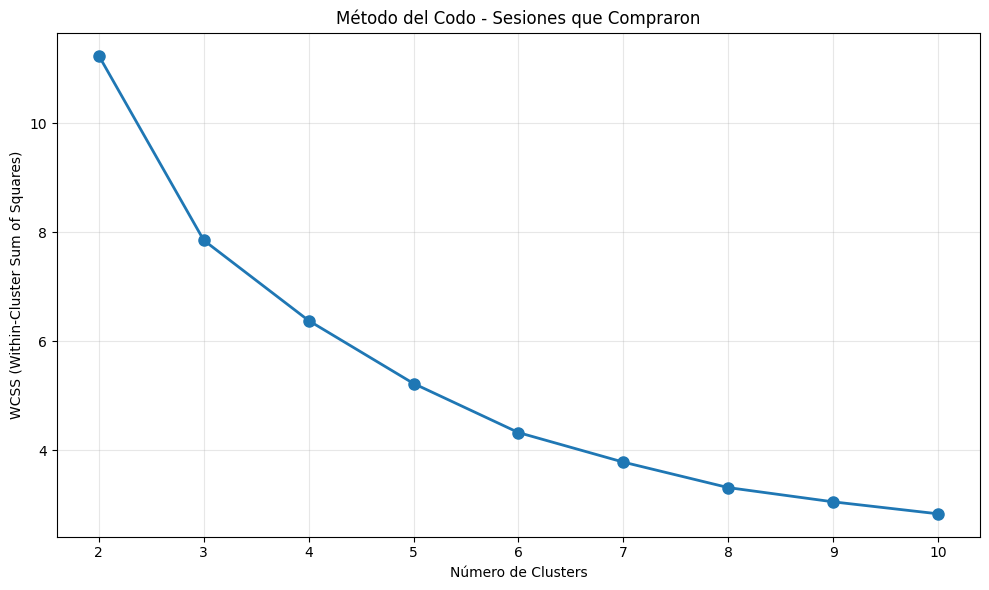

📊 VALORES DE WCSS:
K = 2: WCSS = 11.23
K = 3: WCSS = 7.85
K = 4: WCSS = 6.38
K = 5: WCSS = 5.23
K = 6: WCSS = 4.33
K = 7: WCSS = 3.79
K = 8: WCSS = 3.32
K = 9: WCSS = 3.06
K = 10: WCSS = 2.84


In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calculamos K-Means para cada número de clusters y guardamos WCSS
wcss = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)  # X contiene solo Revenue=True
    wcss.append(kmeans.inertia_)

# Graficamos el elbow plot
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), wcss, marker='o', linewidth=2, markersize=8)
plt.title('Método del Codo - Sesiones que Compraron')
plt.grid(True, alpha=0.3)
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.xticks(range(2, 11))
plt.tight_layout()
plt.show()

# Mostramos valores numéricos para mejor análisis
print("📊 VALORES DE WCSS:")
for k, wcss_val in zip(range(2, 11), wcss):
    print(f"K = {k}: WCSS = {wcss_val:.2f}")

Elección del Número de Clusters (K)

Para determinar el número óptimo de clusters, se utilizó el **Método del Codo (Elbow Method)**, que analiza la inercia (WCSS) a medida que aumenta el número de clusters (K). Los resultados muestran una reducción significativa de la inercia al pasar de K=2 (WCSS=11.23) a K=3 (WCSS=7.85). A partir de K=3, la disminución de la inercia se vuelve menos pronunciada, formando un "codo" en el gráfico.

Aunque el método del codo es una guía, la elección final de K=3 se valida por dos razones clave:

1.  **Interpretabilidad**: Los 3 clusters generados se alinean perfectamente con los perfiles de comprador teóricos ("Explorador", "Nuevo o Desconfiado" y "Directo"), proporcionando un significado claro y accionable.
2.  **Validación Estadística**: Tanto la visualización con t-SNE como los tests ANOVA y Tukey confirmaron que estos 3 grupos son visualmente separables y estadísticamente distintos.

Por lo tanto, K=3 se considera la elección óptima, ya que ofrece el mejor equilibrio entre la simplicidad del modelo y su capacidad para explicar patrones de comportamiento significativos en los datos.